In [1]:
%cd E:\kaggle\iceberg

E:\kaggle\iceberg


In [34]:
import pandas as pd
import numpy as np
import cv2
SEED = 1234
np.random.seed(SEED) 

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation, Concatenate, Input
from keras.models import Model
from keras.utils import plot_model
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam

from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from scipy.ndimage.filters import uniform_filter

In [3]:
def get_scaled_imgs(df):
    imgs = []
    
    for i, row in df.iterrows():
        #make 75x75 image
        band_1 = np.array(row['band_1']).reshape(75, 75)
        band_2 = np.array(row['band_2']).reshape(75, 75)
        band_3 = band_1 + band_2 # plus since log(x*y) = log(x) + log(y)
        
        # Rescale
        a = (band_1 - band_1.mean()) / (band_1.max() - band_1.min())
        b = (band_2 - band_2.mean()) / (band_2.max() - band_2.min())
        c = (band_3 - band_3.mean()) / (band_3.max() - band_3.min())

        imgs.append(np.dstack((a, b, c)))

    return np.array(imgs)

def get_more_images(imgs):
    more_images = []
    vert_flip_imgs = []
    hori_flip_imgs = []
    vh_flip_imgs = []
      
    for i in range(0,imgs.shape[0]):
        vert_flip_imgs.append(cv2.flip(imgs[i], 1))
        hori_flip_imgs.append(cv2.flip(imgs[i], 0))
        vh_flip_imgs.append(cv2.flip(imgs[i], -1))
      
    v = np.array(vert_flip_imgs)
    h = np.array(hori_flip_imgs)
    vh = np.array(vh_flip_imgs)
       
    more_images = np.concatenate((imgs,v,h, vh))
    
    return more_images

In [4]:
def display_img(band_1, band_2, is_iceberg, angle = None):
    if angle is None:
        title_str = 'Iceberg' if is_iceberg == 1 else 'Ship'
    else:
        title_str = 'Iceberg-' + str(angle) if is_iceberg == 1 else 'Ship-' + str(angle)
    fig = plt.figure(0, figsize=(10,10))
    ax = fig.add_subplot(1,2,1)
    ax.set_title(title_str + ' - Band 1')
    ax.imshow(band_1,cmap='jet')
    ax = fig.add_subplot(1,2,2)
    ax.set_title(title_str + ' - Band 2')
    ax.imshow(band_2,cmap='jet')
    plt.show()

# implement functions to convert SAR data from decibel units to linear units and back again
def decibel_to_linear(band):
     # convert to linear units
    return np.power(10,np.array(band)/10)

def linear_to_decibel(band):
    return 10*np.log10(band)

# implement the Lee Filter for a band in an image already reshaped into the proper dimensions
def lee_filter(band, window, var_noise = 0.25):
    # band: SAR data to be despeckled (already reshaped into image dimensions)
    # window: descpeckling filter window (tuple)
    # default noise variance = 0.25
    # assumes noise mean = 0
    
    mean_window = uniform_filter(band, window)
    mean_sqr_window = uniform_filter(band**2, window)
    var_window = mean_sqr_window - mean_window**2

    weights = var_window / (var_window + var_noise)
    band_filtered = mean_window + weights*(band - mean_window)
    return band_filtered

def apply_lee_filter(band_1_linear, band_2_linear, window_var_index = 0, noise_var_index = 0):
    windows = [2, 4, 8] # can be tuple too if not symetric
    noise_var = np.array([1, 2, 4])
    noise_var_1 = np.round(np.var(band_1_linear) * noise_var, 10)
    noise_var_2 = np.round(np.var(band_2_linear) * noise_var, 10)
    band_1_linear_filtered = lee_filter(band_1_linear, windows[window_var_index], noise_var_1[noise_var_index])
    band_2_linear_filtered = lee_filter(band_2_linear, windows[window_var_index], noise_var_2[noise_var_index])
    return band_1_linear_filtered, band_2_linear_filtered

def apply_lee_filter_single(band_linear, window_var_index = 0, noise_var_index = 0):
    windows = [2, 4, 8] # can be tuple too if not symetric
    noise_var = np.array([1, 2, 4])
    noise_var = np.round(np.var(band_linear) * noise_var, 10)
    band_linear_filtered = lee_filter(band_linear, windows[window_var_index], noise_var[noise_var_index])
    return band_linear_filtered

In [4]:
# use_custom_augmentation = True
# if use_custom_augmentation:
#     df_train = pd.read_json('E:/kaggle/iceberg/train.json/data/processed/train.json')
#     df_test = pd.read_json('E:/kaggle/iceberg/test.json/data/processed/test.json')
#     Xtrain = get_scaled_imgs(df_train)
#     Xtest = get_scaled_imgs(df_test)
#     Ytrain = np.array(df_train['is_iceberg'])
    
#     df_train["inc_angle"] = df_train["inc_angle"].replace('na',0)
#     df_test["inc_angle"] = df_test["inc_angle"].replace('na',0)
#     idx_tr = np.where(df_train["inc_angle"]>0)
#     Xtrain = Xtrain[idx_tr[0]]
#     Ytrain = Ytrain[idx_tr[0]]
    
#     Xtrain = get_more_images(Xtrain) 
#     Ytrain = np.concatenate((Ytrain,Ytrain,Ytrain, Ytrain))

In [5]:
# if not use_custom_augmentation:
#     df_train = pd.read_json('E:/kaggle/iceberg/train.json/data/processed/train.json')
#     Xtrain_band_1 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in df_train["band_1"]])
#     Xtrain_band_2 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in df_train["band_2"]])
#     Xtrain_band_3 = Xtrain_band_1 + Xtrain_band_2

#     Xtrain = np.concatenate([Xtrain_band_1[:, :, :, np.newaxis], Xtrain_band_2[:, :, :, np.newaxis], Xtrain_band_3[:, :, :, np.newaxis]], axis=-1)
#     Ytrain = df_train["is_iceberg"].values

#     df_train["inc_angle"] = df_train["inc_angle"].replace('na',0)
#     idx_tr = np.where(df_train["inc_angle"]>0)

#     Xtrain = Xtrain[idx_tr[0]]
#     Ytrain = Ytrain[idx_tr[0]]

#     df_test = pd.read_json('E:/kaggle/iceberg/test.json/data/processed/test.json')
#     Xtest_band_1 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in df_test["band_1"]])
#     Xtest_band_2 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in df_test["band_2"]])
#     Xtest_band_3 = Xtest_band_1 + Xtest_band_2

#     Xtest = np.concatenate([Xtest_band_1[:, :, :, np.newaxis], Xtest_band_2[:, :, :, np.newaxis], Xtest_band_3[:, :, :, np.newaxis]], axis=-1)

#     df_test["inc_angle"] = df_test["inc_angle"].replace('na',0)

In [14]:
use_custom_augmentation = False
if use_custom_augmentation:
    df_train = pd.read_json('E:/kaggle/iceberg/train.json/data/processed/train.json')
    df_test = pd.read_json('E:/kaggle/iceberg/test.json/data/processed/test.json')
    Xtrain = get_scaled_imgs(df_train)
    Xtest = get_scaled_imgs(df_test)
    Ytrain = np.array(df_train['is_iceberg'])
    
    df_train["inc_angle"] = df_train["inc_angle"].replace('na',0)
    df_test["inc_angle"] = df_test["inc_angle"].replace('na',0)
    idx_tr = np.where(df_train["inc_angle"]>0)
    Xtrain = Xtrain[idx_tr[0]]
    Ytrain = Ytrain[idx_tr[0]]
    
    Xtrain = get_more_images(Xtrain) 
    Ytrain = np.concatenate((Ytrain,Ytrain,Ytrain, Ytrain))
else:
    train = pd.read_json("E:/kaggle/iceberg/train.json/data/processed/train.json")
    target_train=train['is_iceberg']
    test = pd.read_json("E:/kaggle/iceberg/test.json/data/processed/test.json")
#     train['inc_angle']=pd.to_numeric(train['inc_angle'], errors='coerce')#We have only 133 NAs.
#     train['inc_angle']=train['inc_angle'].fillna(method='pad')
    train["inc_angle"] = train["inc_angle"].replace('na',0)
    idx_tr = np.where(train["inc_angle"]>0)
    train = train.iloc[idx_tr[0]]
    target_train = target_train.iloc[idx_tr[0]]
    X_angle=train['inc_angle']
#     test['inc_angle']=pd.to_numeric(test['inc_angle'], errors='coerce')
    test['inc_angle']=test['inc_angle'].fillna(method='pad')
    X_test_angle=test['inc_angle']
    
    #Generate the training data
    X_band_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_1"]])
    X_band_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_2"]])
    #apply filter
    X_band_1_filtered = np.array([apply_lee_filter_single(decibel_to_linear(band)) for band in X_band_1])
    X_band_2_filtered = np.array([apply_lee_filter_single(decibel_to_linear(band)) for band in X_band_2])
    X_band_1_filtered = linear_to_decibel(X_band_1_filtered)
    X_band_2_filtered = linear_to_decibel(X_band_2_filtered)
    X_band_1 = X_band_1_filtered
    X_band_2 = X_band_2_filtered

    X_band_3=np.fabs(np.subtract(X_band_1,X_band_2))
    X_band_4=np.maximum(X_band_1,X_band_2)
    X_band_5=np.minimum(X_band_1,X_band_2)
    X_train = np.concatenate([X_band_3[:, :, :, np.newaxis],X_band_4[:, :, :, np.newaxis],X_band_5[:, :, :, np.newaxis]], axis=-1)

    X_band_test_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_1"]])
    X_band_test_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_2"]])
    #apply filter
    X_band_test_1_filtered = np.array([apply_lee_filter_single(decibel_to_linear(band)) for band in X_band_test_1])
    X_band_test_2_filtered = np.array([apply_lee_filter_single(decibel_to_linear(band)) for band in X_band_test_2])
    X_band_test_1_filtered = linear_to_decibel(X_band_test_1_filtered)
    X_band_test_2_filtered = linear_to_decibel(X_band_test_2_filtered)
    X_band_test_1 = X_band_test_1_filtered
    X_band_test_2 = X_band_test_2_filtered

    X_band_test_3=np.fabs(np.subtract(X_band_test_1,X_band_test_2))
    X_band_test_4=np.maximum(X_band_test_1,X_band_test_2)
    X_band_test_5=np.minimum(X_band_test_1,X_band_test_2)
    X_test = np.concatenate([X_band_test_3[:, :, :, np.newaxis], X_band_test_4[:, :, :, np.newaxis],X_band_test_5[:, :, :, np.newaxis]],axis=-1)
    
    X_train = get_more_images(X_train)
    target_train = np.concatenate((target_train, target_train, target_train, target_train))
    X_angle = np.concatenate((X_angle, X_angle, X_angle, X_angle))
    
    Xtrain = X_train
    Ytrain = target_train
    Xtest = X_test
    Xangle = X_angle
    Xangle_test = X_test_angle
    df_train = train
    df_test = test

(5884, 75, 75, 3) (5884,) (5884,) (8424, 75, 75, 3)


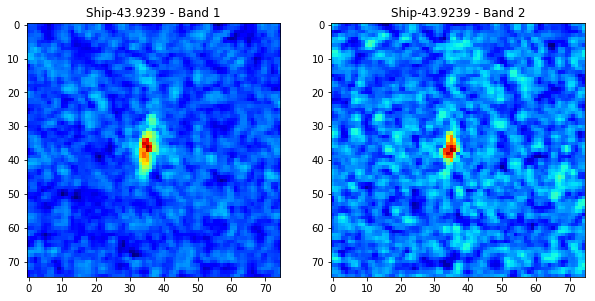

In [15]:
print(Xtrain.shape, Ytrain.shape, Xangle.shape, Xtest.shape)
display_img(X_band_1[0], X_band_2[0], target_train[0], X_angle[0])

In [16]:
# def getModel():
#     #Build keras model
    
#     model=Sequential()
    
#     # CNN 1
#     model.add(Conv2D(64, kernel_size=(3, 3),activation='relu', input_shape=(75, 75, 3)))
#     model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
#     model.add(Dropout(0.2))

#     # CNN 2
#     model.add(Conv2D(128, kernel_size=(3, 3), activation='relu' ))
#     model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
#     model.add(Dropout(0.2))

#     # CNN 3
#     model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
#     model.add(Dropout(0.3))

#     #CNN 4
#     model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
#     model.add(Dropout(0.3))

#     # You must flatten the data for the dense layers
#     model.add(Flatten())

#     #Dense 1
#     model.add(Dense(512, activation='relu'))
#     model.add(Dropout(0.2))

#     #Dense 2
#     model.add(Dense(256, activation='relu'))
#     model.add(Dropout(0.2))

#     # Output 
#     model.add(Dense(1, activation="sigmoid"))

#     optimizer = Adam(lr=0.001, decay=0.0)
#     model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
#     return model

In [35]:
def getModel():
    #Build keras model
    angle_input = Input(shape=[1], name="angle")
    angle_layer = Dense(1)(angle_input)
    img_input = Input(shape=Xtrain.shape[1:], name="img")
    
    # CNN 1
    x = Conv2D(64, kernel_size=(3, 3), activation='relu')(img_input)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)
    x = Dropout(0.2)(x)

    # CNN 2
    x = Conv2D(128, kernel_size=(3, 3), activation='relu' )(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = Dropout(0.2)(x)

    # CNN 3
    x = Conv2D(128, kernel_size=(3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = Dropout(0.3)(x)

    #CNN 4
    x = Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = Dropout(0.3)(x)

    # You must flatten the data for the dense layers
    x = Flatten()(x)

    #Dense 1
    fc = Dense(512, activation='relu')(x)
    fc = Dropout(0.2)(fc)

    #Dense 2
    fc = Dense(256, activation='relu')(fc)
    fc = Dropout(0.2)(fc)
    
    #angle fuse
    fc = Concatenate()([fc, angle_layer])
                     
    # Output 
    predictions = Dense(1, activation="sigmoid")(fc)
    
    model = Model(inputs=[img_input, angle_input], outputs=predictions)
                     
    optimizer = Adam(lr=1e-3, decay=0.0)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model

In [36]:
model = getModel()
model.summary()
plot_model(model, "basic_cnn.png")

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
img (InputLayer)                 (None, 75, 75, 3)     0                                            
____________________________________________________________________________________________________
conv2d_25 (Conv2D)               (None, 73, 73, 64)    1792        img[0][0]                        
____________________________________________________________________________________________________
max_pooling2d_25 (MaxPooling2D)  (None, 36, 36, 64)    0           conv2d_25[0][0]                  
____________________________________________________________________________________________________
dropout_37 (Dropout)             (None, 36, 36, 64)    0           max_pooling2d_25[0][0]           
___________________________________________________________________________________________

In [18]:
batch_size = 64
earlyStopping = EarlyStopping(monitor='val_loss', patience=20, mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')
# Define the image transformations here
use_zca_whitening = True
gen = ImageDataGenerator(horizontal_flip = False,
                         vertical_flip = False,
                         samplewise_center = True,# check
                         zca_whitening=use_zca_whitening,# check
                         width_shift_range = 0.,
                         height_shift_range = 0.,
                         channel_shift_range=0,
                         zoom_range = 0.5,
                         rotation_range = 10)

# Here is the function that merges our two generators
# We use the exact same generator with the same random seed for both the y and angle arrays
def gen_flow_for_two_inputs(X1, X2, y):
    if use_zca_whitening:
        gen.fit(X1)
    genX1 = gen.flow(X1,y,  batch_size=batch_size,seed=55)
    genX2 = gen.flow(X1,X2, batch_size=batch_size,seed=55)
    while True:
        X1i = genX1.next()
        X2i = genX2.next()
        #Assert arrays are equal - this was for peace of mind, but slows down training
        #np.testing.assert_array_equal(X1i[0],X2i[0])
        yield [X1i[0], X2i[1]], X1i[1]

In [40]:
K=3
Kfolds = list(StratifiedKFold(n_splits=K, shuffle=True, random_state=SEED).split(Xtrain, Ytrain))
y_test_pred_log = 0
useGen = True
useAngle = True
epochs = 100
for j, (train_idx, test_idx) in enumerate(Kfolds):
    print('\n===================FOLD=',j)
    Xtrain_cv = Xtrain[train_idx]
    Ytrain_cv = Ytrain[train_idx]
    Xangle_cv = Xangle[train_idx]
    Xtrain_val = Xtrain[test_idx]
    Ytrain_val = Ytrain[test_idx]
    Xangle_val = Xangle[test_idx]
    
    model_file = 'model_%s.hdf5' % j
    
    mcp_save = ModelCheckpoint(model_file, save_best_only=True, monitor='val_loss', mode='min')
    model = getModel()
    
    if useGen and useAngle:
        gen_flow = gen_flow_for_two_inputs(Xtrain_cv, Xangle_cv, Ytrain_cv)
        Xtrain_val = [Xtrain_val, Xangle_val]
        Xtrain_input = [Xtrain, Xangle]
        Xtest_input = [Xtest, Xangle_test]
    elif useAngle:
        Xtrain_cv = [Xtrain_cv, Xangle_cv]
        Xtrain_val = [Xtrain_val, Xangle_val]
        Xtrain_input = [Xtrain, Xangle]
        Xtest_input = [Xtest, Xangle_test]
    else:
        Xtrain_input = Xtrain
        Xtest_input = Xtest
        
    if useGen:
        model.fit_generator(gen_flow, steps_per_epoch=int(len(Xtrain_cv) / batch_size), epochs=epochs, shuffle=True, verbose=1, callbacks=[
            earlyStopping, 
            mcp_save, 
            reduce_lr_loss, 
    #       tensorboard  
        ], validation_data=(Xtrain_val, Ytrain_val))
    else:
        model.fit(Xtrain_cv, Ytrain_cv, batch_size=batch_size, epochs=epochs, verbose=1, callbacks=[earlyStopping, mcp_save, reduce_lr_loss], validation_data=(Xtrain_val, Ytrain_val))

    model.load_weights(filepath = model_file)    
    
    score = model.evaluate(Xtrain_input, Ytrain, verbose=1)
    print('Train score:', score[0])
    print('Train accuracy:', score[1])
    y_test_pred_log += model.predict(Xtest_input).reshape(Xtest.shape[0])
    
y_test_pred_log /= K


===================FOLD= 0
5884/5884 [==============================] - 16s    
Train score: 0.149810824956
Train accuracy: 0.945445275404

===================FOLD= 1
Epoch 1/100
61/61 [==============================] - 42s - loss: 0.6549 - acc: 0.6537 - val_loss: 0.5295 - val_acc: 0.7226
Epoch 2/100
61/61 [==============================] - 40s - loss: 0.4777 - acc: 0.7724 - val_loss: 0.4673 - val_acc: 0.7680
Epoch 3/100
61/61 [==============================] - 39s - loss: 0.4394 - acc: 0.8045 - val_loss: 0.4182 - val_acc: 0.8358
Epoch 4/100
61/61 [==============================] - 38s - loss: 0.4322 - acc: 0.8094 - val_loss: 0.4390 - val_acc: 0.7904
Epoch 5/100
61/61 [==============================] - 40s - loss: 0.4179 - acc: 0.8087 - val_loss: 0.4148 - val_acc: 0.8021
Epoch 6/100
61/61 [==============================] - 39s - loss: 0.3980 - acc: 0.8190 - val_loss: 0.3653 - val_acc: 0.8368
Epoch 7/100
61/61 [==============================] - 39s - loss: 0.3924 - acc: 0.8317 - val_lo

61/61 [==============================] - 42s - loss: 0.2299 - acc: 0.9049 - val_loss: 0.2210 - val_acc: 0.9041
Epoch 65/100
61/61 [==============================] - 42s - loss: 0.2271 - acc: 0.9075 - val_loss: 0.2146 - val_acc: 0.9123
Epoch 66/100
61/61 [==============================] - 43s - loss: 0.2233 - acc: 0.9108 - val_loss: 0.2170 - val_acc: 0.9118
Epoch 67/100
61/61 [==============================] - 44s - loss: 0.2223 - acc: 0.9114 - val_loss: 0.2082 - val_acc: 0.9159
Epoch 68/100
61/61 [==============================] - 42s - loss: 0.2227 - acc: 0.9085 - val_loss: 0.2091 - val_acc: 0.9153
Epoch 69/100
61/61 [==============================] - 43s - loss: 0.2096 - acc: 0.9113 - val_loss: 0.2032 - val_acc: 0.9148
Epoch 70/100
61/61 [==============================] - 42s - loss: 0.2259 - acc: 0.9038 - val_loss: 0.1990 - val_acc: 0.9225
Epoch 71/100
61/61 [==============================] - 44s - loss: 0.2212 - acc: 0.9093 - val_loss: 0.1980 - val_acc: 0.9215
Epoch 72/100
61/61 [=

61/61 [==============================] - 45s - loss: 0.2795 - acc: 0.8834 - val_loss: 0.2671 - val_acc: 0.8842
Epoch 30/100
61/61 [==============================] - 46s - loss: 0.3017 - acc: 0.8677 - val_loss: 0.2397 - val_acc: 0.9077
Epoch 31/100
61/61 [==============================] - 46s - loss: 0.2837 - acc: 0.8715 - val_loss: 0.2246 - val_acc: 0.9087
Epoch 32/100
61/61 [==============================] - 45s - loss: 0.2852 - acc: 0.8749 - val_loss: 0.2484 - val_acc: 0.8929
Epoch 33/100
61/61 [==============================] - 46s - loss: 0.2849 - acc: 0.8798 - val_loss: 0.2601 - val_acc: 0.8914
Epoch 34/100
61/61 [==============================] - 47s - loss: 0.2845 - acc: 0.8797 - val_loss: 0.2447 - val_acc: 0.9006
Epoch 35/100
61/61 [==============================] - 46s - loss: 0.2760 - acc: 0.8781 - val_loss: 0.3549 - val_acc: 0.8389
Epoch 36/100
61/61 [==============================] - 45s - loss: 0.3114 - acc: 0.8698 - val_loss: 0.3416 - val_acc: 0.8491
Epoch 37/100
61/61 [=

61/61 [==============================] - 42s - loss: 0.1859 - acc: 0.9265 - val_loss: 0.2002 - val_acc: 0.9230
Epoch 93/100
61/61 [==============================] - 42s - loss: 0.1979 - acc: 0.9212 - val_loss: 0.2002 - val_acc: 0.9225
Epoch 94/100
61/61 [==============================] - 44s - loss: 0.1917 - acc: 0.9235 - val_loss: 0.1989 - val_acc: 0.9261
Epoch 95/100
61/61 [==============================] - 43s - loss: 0.1904 - acc: 0.9300 - val_loss: 0.2006 - val_acc: 0.9235
Epoch 96/100
61/61 [==============================] - 42s - loss: 0.1888 - acc: 0.9238 - val_loss: 0.1993 - val_acc: 0.9210
Epoch 97/100
61/61 [==============================] - 42s - loss: 0.1885 - acc: 0.9230 - val_loss: 0.1995 - val_acc: 0.9245
Epoch 98/100
61/61 [==============================] - 42s - loss: 0.1919 - acc: 0.9228 - val_loss: 0.2007 - val_acc: 0.9225
Epoch 99/100
61/61 [==============================] - 41s - loss: 0.1800 - acc: 0.9260 - val_loss: 0.2000 - val_acc: 0.9245
Epoch 100/100
5884/58

In [41]:
submission = pd.DataFrame({'id': df_test["id"], 'is_iceberg': y_test_pred_log.reshape(y_test_pred_log.shape[0])})
print(submission.head(10))
print(submission.count(), Xtest.shape[0])

submission.to_csv('submission-cnn-custom.csv', index=False)

         id    is_iceberg
0  5941774d  1.965353e-01
1  4023181e  3.879364e-01
2  b20200e4  3.209522e-07
3  e7f018bb  9.962336e-01
4  4371c8c3  5.066199e-03
5  a8d9b1fd  4.198272e-01
6  29e7727e  5.725038e-02
7  92a51ffb  9.907501e-01
8  c769ac97  1.245574e-04
9  aee0547d  4.414778e-24
id            8424
is_iceberg    8424
dtype: int64 8424
